<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week10/Dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning - Week 10
# Dimensionality Reduction

Dimensionality reduction is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data.

Useful for:
* Classification (improve accuracy by removing noise in data)
* Data visualization

### Table of Contents
#### 1. Basic Examples
* 1.1 Visualization with PCA
* 1.2 PCA: exercise
* 1.3 MDS

#### 2. SMS Classification: with PCA vs. without PCA
* 2.1 Load and explore data
* 2.2 Train test split
* 2.3 Clean and Vectorize text
* 2.4 PCA
* 2.5 Logistic regression
* 2.6 KNN

#### 3. Text data vizualisation with t-SNE
* 3.1 SMS
* 3.2 Complaints

Author: Luc Kunz

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use('dark_background')

# Set seed
seed = np.random.RandomState(seed=42)

## 1. Basic Examples
We review some of the concepts seen in class using basic examples.

### 1.1 Visualization with PCA

PCA idea: project data points in the lower dimensional space in the direction that retains maximum variance.


![PCA](http://lazyprogrammer.me/wp-content/uploads/2015/11/PCA.jpg)

In the following, we use cancer data that can be found [here](https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset).

In [ ]:
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week10/data/Breast_cancer_data.csv')
df.head()

We have 5 features (`mean_radius`, `means_texture`, `mean_perimeter`, `mean_area`, `mean_smoothness`) and 1 class (`diagnosis`). We want to use the features to predict the class.

In [ ]:
# Correlation
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)

There are some high correlations, so PCA may be useful.

In [ ]:
# Select features
X = df.drop(['diagnosis'], axis=1)
X

Sometimes PCA works better with Standardization. Try with and without to see the difference.

In [5]:
# Standardize data
from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit_transform(X)
#X

In [ ]:
# Apply PCA - 2 components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pd.DataFrame(pca.fit_transform(X), columns=['Principal Component 1', 'Principal Component 2'])
print(pca.explained_variance_ratio_)
print('Ratio of variance expalined with the two components: ', round(sum(pca.explained_variance_ratio_), 6))
result

In [ ]:
# Concat
result['diagnosis'] = df['diagnosis']
result

In [ ]:
# Plot
sns.pairplot(result, hue='diagnosis')

We can see a clear separation between classes. Indeed, thanks to PCA, we were able to visualise this. It is then easy to apply a classification algorithm. This will have a great precision.

### 1.2 PCA: exercise

To do in groups (10 minutes): follow the steps and send your answers and code @Luc Kunz on Slack (direct message). One answer per person. Deadline: tomorrow (Dec 1, 2020) at 6pm. This is a good way to improve your participation grade.

We want to further illustrate PCA. For this let's define a function that returns coordinates of a plane.

In [ ]:
# Plane function -> ax + by + cz = d + e
def noisy_plane(a, b, c, d, noise, n):
  """Function returns n points belonging to a plane in 3D."""
  # Generate n points
  x = 100*seed.random(n-2)
  x = np.append(x, 200)
  x = np.append(x, 50)
  y = 100*seed.random(n-2)
  y = np.append(y, 50)
  y = np.append(y, 200)
  # Noise
  e = seed.normal(0, noise, n)
  # Calculate the third coordinate of the plane
  z = (d - a*x - b*y + e)/c
  # Make and return DataFrame
  df = pd.DataFrame(np.array([x,y,z])).transpose()
  df.columns = ['x', 'y', 'z']
  return df

# Number of points
n_samples = 500

# Plane with noise of 50
df = noisy_plane(-2, -1, -3, 0, 50, n_samples)
df

In [ ]:
# Plot in 3D
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")
ax.scatter(df.x, df.y, df.z, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

We have a plane in three-dimensional space. In addition, we have two points that are a little further away from the plane. We use PCA with 2 components.

In [11]:
# 1. Implement PCA with 2 components: What is the explained variance ratio of the first component?
# [YOUR CODE HERE]

In [12]:
# 2. Plot the two components using a scatter plot. What do you observe?
# [YOUR CODE HERE]

### 1.3 MDS
We also provide an example with the multi-dimensional scale. Idea: lower dimensionality using **distances** between points. Documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).


In [ ]:
# Plane without noise
df = noisy_plane(-2, -1, -3, 0, 0, n_samples)
df

In [ ]:
# Standardize data - because we calculate distances
df_standardized = StandardScaler().fit_transform(df)
df_standardized

In [ ]:
# Compute distances
from sklearn.metrics import euclidean_distances

similarities = euclidean_distances(df_standardized)
similarities[:3]

In [ ]:
# Add noise to distances
noise = (np.random.rand(n_samples, n_samples) - 0.5)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise
similarities[:3]

In [ ]:
# MSD
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=100000, eps=1e-12, random_state=seed,
                   dissimilarity='precomputed', n_jobs=-1)
pos = pd.DataFrame(mds.fit_transform(similarities))
pos

In [ ]:
# Plot projection
plt.figure(figsize=(10,7))
plt.scatter(pos[0], pos[1])

## 2. SMS Classification: with vs. without PCA
We classify SMS as `ham` or `spam` using logistic regression and KNN with and without PCA. Data can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

### 2.1 Load and explore data

In [ ]:
# Load data from GitHub
path = "https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week10/data/spam.csv"
data = pd.read_csv(path, encoding='latin-1')
data.head()

We want to predict the label (v1) based on the text of the message (v2).

In [ ]:
data.info()

In [ ]:
# Select text only
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
data = data.rename(columns = {'v1':'label','v2':'message'})
data.head()

In [ ]:
data.info()

In [ ]:
# A bit of EDA
data.groupby('label').describe()

In [ ]:
# Imbalanced dataset
plt.figure(figsize=(10,7))
sns.countplot(data.label)
plt.show()

In [ ]:
# Base rate
data.label.value_counts(normalize=True)

In [26]:
# Select variables
X = data.message
y = data.label

### 2.2 Train test split


In [ ]:
# Import function
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
X_train

### 2.3 Clean and vectorize text
We use the `re` and `nltk` packages for cleaning.

In [ ]:
# Import and download packages
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


# Define cleaning function
def data_cleaner(sms):

    # Define stopwords
    stop_words = stopwords.words('english')

    # Define tokenizer and stemmer
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer
    
    # Remove digits
    sms = re.sub(r"\d+","", sms)
    
    # Lowercase
    sms = sms.lower()
    
    # Remove punctuation
    sms = re.sub(r"[^\w\s\d]","", sms)
    
    # Remove stop words
    sms = sms.split()
    sms = " ".join([word for word in sms if not word in stop_words])
    
    # Tokenize
    sms = word_tokenize(sms)
    
    # Stemming
    ps = PorterStemmer()
    sms = [ps.stem(word) for word in sms]
    
    return sms

# Clean X_train as example
X_train.apply(data_cleaner)

It's not perfect but it's already great :) 
We further use TF-IDF to vectorize the messages.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf = TfidfVectorizer(sublinear_tf=True, tokenizer=data_cleaner, ngram_range=(1,1), min_df=3, max_df=0.9)

# Fit and transform X_train and X_test
X_train_vec = tfidf.fit_transform(X_train).toarray()
X_test_vec = tfidf.transform(X_test).toarray()
print(X_train_vec.shape)
X_train_vec

As we can see, `X_train_vec` has a dimensionality of 1957. We use PCA to lower this to 100.

### 2.4 PCA

In [ ]:
# Define Scaler
scaler = StandardScaler()

# Define PCA
pca = PCA(n_components=100)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

### 2.5 Logistic Regression
We apply logistic regression 4 times:
* Without PCA and Standardization
* With Standardization
* With PCA
* With Standardization and PCA

We then compare the time to run and the accuracy on training and test sets.

In [ ]:
# Without PCA and Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([
                 ('logistic reg', LogisticRegression())
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In [ ]:
# With Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('logistic reg', LogisticRegression())
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In [ ]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('logistic reg', LogisticRegression()),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In [ ]:
# With PCA and standardization

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('logistic reg', LogisticRegression(max_iter=3000)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

We can see that the best results are obtained in the second case:
* With Standardization

In this case, standardization increases the performance, but PCA does not.

### 2.6 KNN
We apply KNN 4 times:
* Without PCA
* With Standardization
* With PCA
* With Standardization and PCA

We then compare the time to run and the accuracy on training and test sets.

In [35]:
# Change number of components - only 10
pca = PCA(n_components=10)

In [ ]:
# Without PCA and Standardization
from sklearn.neighbors import KNeighborsClassifier

# Define Model
pipe = Pipeline([
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In [ ]:
# With Standardization

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In [ ]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In [ ]:
# With PCA and standardization

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

In this case, PCA increases the accuraccy but standardization does not. In addition, the time to run is lower with PCA.

#### Conclusion: PCA and standardization are useful tools that could help increase the accuracy and/or lower execution time.

## 3. Text data vizualisation with t-SNE
Finally, we show t-SNE. Documentation is available [here](https://www.scikit-yb.org/en/latest/api/text/tsne.html) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

### 3.1 SMS
We use the train data.

In [ ]:
X = pd.DataFrame(X_train_vec)
X

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# t-sne on training data
from yellowbrick.text import TSNEVisualizer

# Create the visualizer and draw the vectors
plt.figure(figsize=(10,7))
tsne = TSNEVisualizer(colormap='Dark2')
tsne.fit(X_train_vec, y_train)

In only 2 dimensions, we can already see the two classes.

### 3.2 Complaints

In [ ]:
# Import, clean, prepare
path = "https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week7/data/complaints_sample.csv"
df = pd.read_csv(path, index_col=0)

# Select columns of interest
data = df[["Product", "Consumer complaint narrative"]]
data.head()

# Drop NaN
print(data.isnull().sum())
data = data.dropna().reset_index(drop=True)
data.head()

# Clean
dic_replace = {'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports', 
               'Credit card':'Credit card or prepaid card', 
               'Payday loan':'Payday loan, title loan, or personal loan', 
               'Money transfers':'Money transfer, virtual currency, or money service',
               'Prepaid card':'Credit card or prepaid card',
               'Virtual currency':'Money transfer, virtual currency, or money service'}
data.replace(dic_replace, inplace=True)
data.Product.value_counts()

In [43]:
import spacy
import string

# Load English language model of spacy
sp = spacy.load('en_core_web_sm')


# Define tokenizer function
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Remove anonymous dates and people
    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

    # Return preprocessed list of tokens
    return mytokens

# Select features
X = data['Consumer complaint narrative'] # the features we want to analyze
ylabels = data['Product'] # the labels, or answers, we want to test against

# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Vectorize
X_vec = tfidf.fit_transform(X)
X_vec = pd.DataFrame(X_vec.toarray())
X_vec

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8060,8061,8062,8063,8064,8065,8066,8067,8068,8069,8070,8071,8072,8073,8074,8075,8076,8077,8078,8079,8080,8081,8082,8083,8084,8085,8086,8087,8088,8089,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fe116d4c668>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

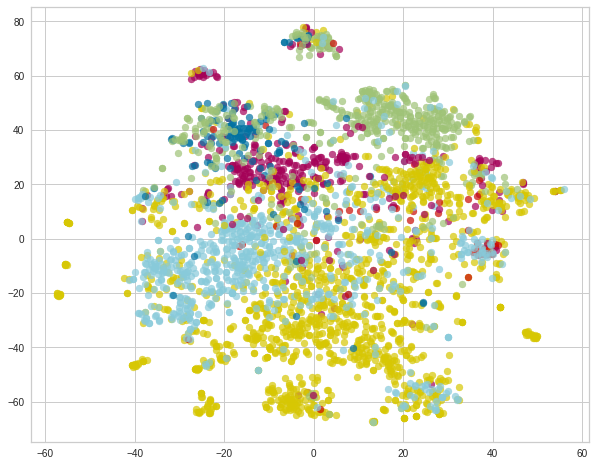

In [44]:
# t-sne
plt.figure(figsize=(10,8))
tsne = TSNEVisualizer()
tsne.fit(X_vec, ylabels)

## References

* https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc
* https://www.kaggle.com/datatattle/battle-of-ml-classification-models

